In [1]:
import numpy as np
import pandas as pd
import os

# custom imports
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import glob

In [2]:
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


# Convert run-length encoded pixels to masks

In [3]:
def pixel_decode(px: int, rows: int) -> (int, int):
    x = (px - 1) // rows
    y = (px - 1) % rows
    return x, y

# rle = run-length encoding
def rle2mask(rle_string, shape):
    rle_list = list(map(int, rle_string.split()))
    
    decoded_pixels = np.zeros(shape, dtype=np.float32)
    rows = shape[0]
    for i in range(0, len(rle_list), 2):
        rle_px = rle_list[i]
        pixel_count = rle_list[i + 1] - 1
        
        x, y = pixel_decode(rle_px, rows)
        
        decoded_pixels[y:y+pixel_count, x] = 1
    
    return decoded_pixels

In [4]:
def generate_masks(df, image_id, shape):
    pixel_masks = []
    for class_id in range(1, 5):        
        image_defects = train_df[(df['ImageId'] == image_id) & (df['ClassId'] == class_id)]
        if image_defects.empty:
            pixel_mask = np.zeros(shape, dtype=np.float32)
        else:
            rle_pixel = str(image_defects['EncodedPixels'].iloc[0])
            pixel_mask = rle2mask(rle_pixel, shape)
            
        pixel_masks.append(pixel_mask)
    
    return np.stack(pixel_masks, axis=-1)

# Load Data

In [5]:
train_df = pd.read_csv("data/train.csv")
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [6]:
num_images = 4000
image_shape = (128, 800)

In [7]:
train_image_base_path = "data/train_images/"
train_image_file_extension = "*.jpg"
train_image_path = os.path.join(train_image_base_path, train_image_file_extension)
train_image_names = [os.path.basename(path) for path in glob.glob(train_image_path)]
train_image_names.sort()
print(len(train_image_names))

train_image_subset = train_image_names[0:num_images]
train_image_dataset = np.array(train_image_subset)

print(train_image_dataset.shape)

12568
(4000,)


# Sanity check, view few images

In [8]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# https://www.kaggle.com/code/cdeotte/keras-unet-with-eda#Keras-Segmentation-Models

import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, path, image_ids, validation_df, new_dim = (128, 800, 3), resize_factor = 2, batch_size = 16, n_classes = 4, shuffle=True):
        super().__init__()
        self.path = path
        self.image_ids = image_ids
        self.validation_df = validation_df
        self.dim = new_dim
        self.resize_factor = resize_factor
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index * self.batch_size:(index+1)*self.batch_size]
        
        list_ids_temp = [self.image_ids[k] for k in indexes]
        
        X, y = self.__data_generation(list_ids_temp)
        
        return X, y
        
    def __data_generation(self, list_ids_temp):
        # Initialization
        height = self.dim[0]
        width = self.dim[1]
        X = np.empty((self.batch_size, *self.dim), dtype=np.float32)
        y = np.empty((self.batch_size, height, width, self.n_classes), dtype=np.float32)
        
        for i, image_id in enumerate(list_ids_temp):
            image_path = os.path.join(self.path, image_id)
            image = cv2.imread(image_path, 1)
            resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_NEAREST)
            normalized_image = resized_image / 255.0
            X[i,] = normalized_image
            
            masks = generate_masks(self.validation_df, image_id, (height * self.resize_factor, width * self.resize_factor))
            resized_masks = [cv2.resize(masks[:,:,j], (width, height), interpolation=cv2.INTER_NEAREST) for j in range(self.n_classes)]
            y[i,] = np.stack(resized_masks, axis=-1)
            
            
        return X, y        

2024-05-27 15:26:46.642988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 15:26:46.643082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 15:26:46.761474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
example_images = train_image_subset[:16]
print(len(train_image_dataset))
example_batch = DataGenerator(train_image_base_path,
                              train_image_dataset,
                              train_df,
                              shuffle=False
                             )
x_ex = example_batch[0][0]
y_ex = example_batch[0][1]

4000


In [10]:
# check whether all 3 channels hold the same data
channel_0 = x_ex[:, :, 0]
channel_1 = x_ex[:, :, 1]
channel_2 = x_ex[:, :, 2]

channels_identical = np.array_equal(channel_0, channel_1) and np.array_equal(channel_1, channel_2)

if channels_identical:
    print("The three channels are identical.")
else:
    print("The three channels are not identical.")

The three channels are not identical.


12


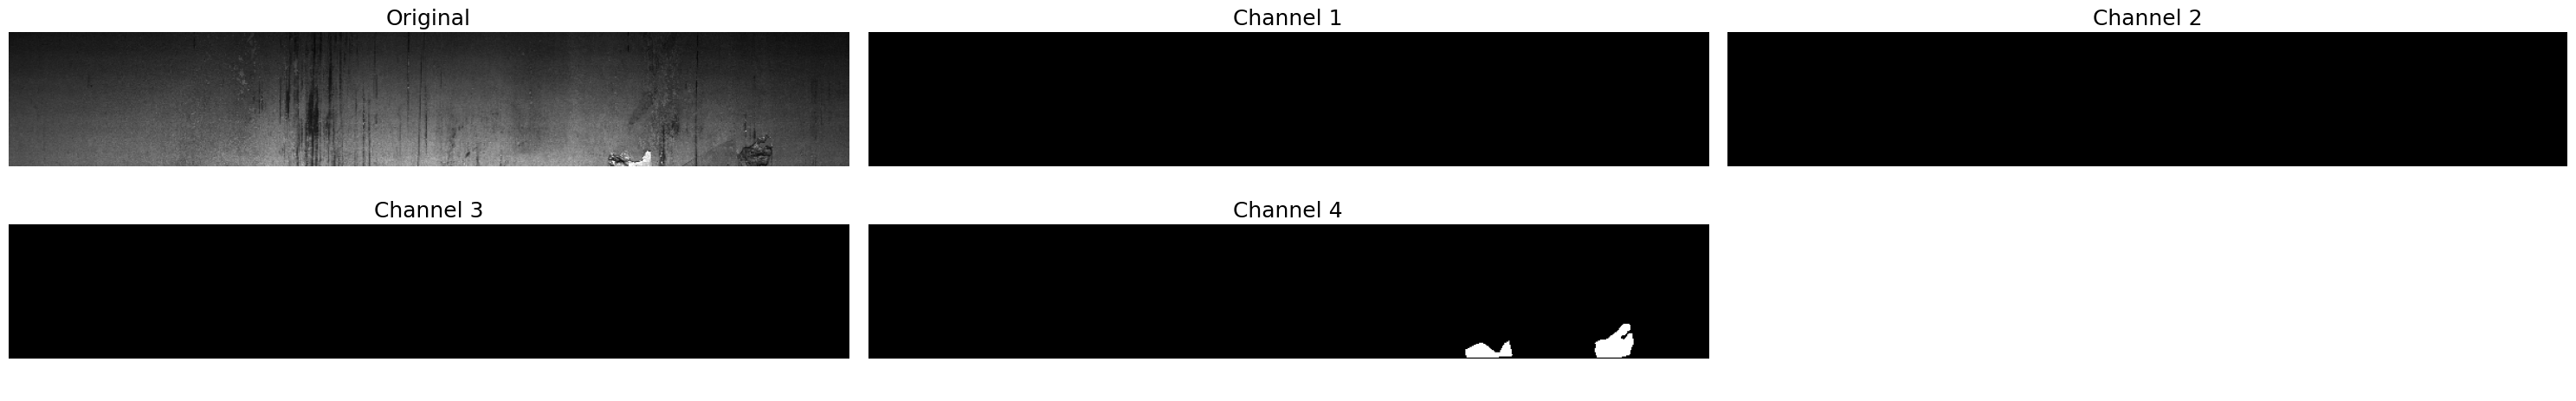

In [11]:
import random

image_number =  random.randint(0, 15)
print(image_number)
random_image = example_batch[0][0][image_number]
random_mask = example_batch[0][1][image_number]
fig, axes = plt.subplots(2, 3, figsize=(30, 5))

# Display the original image in the first subplot
axes[0, 0].imshow(random_image[:,:,0], cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# Iterate over the 4 channels
for i in range(4):
    row = (i + 1) // 3
    col = (i + 1) % 3
    ax = axes[row, col]
    ax.imshow(random_mask[:, :, i], cmap='gray')
    ax.set_title(f'Channel {i + 1}')
    ax.axis('off')  # Turn off axis

# Turn off the remaining empty subplot
axes[1, 2].axis('off')

# Display the plots
plt.tight_layout()
plt.show()


In [12]:
print("Image data shape is: ", x_ex.shape)
print("Mask data shape is: ", y_ex.shape)
print("Unique values in images: ", np.unique(x_ex))
for i in range(4):
    print(f"Unique values in mask {i}: {np.unique(y_ex[:, :, :, i])}")

In [13]:
from tensorflow.keras import backend as K
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

# COMPETITION METRIC
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [15]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore, FScore

BACKBONE = "resnet34"# 'efficientnetb3'
# activation = "softmax" # because of multiclass model
activation = 'sigmoid'
n_classes = 4 # number of labels 

# create model
model = sm.Unet(BACKBONE, input_shape=(128, 800, 3), classes = n_classes, activation=activation) 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

Segmentation Models: using `tf.keras` framework.
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(16, 128, 800, 3)


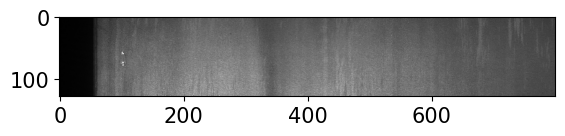

Epoch 1/30


I0000 00:00:1716823728.802670     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 231s 625ms/step - dice_coef: 0.0168 - loss: 0.2519 - val_dice_coef: 0.0079 - val_loss: 0.0454
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 94s 454ms/step - dice_coef: 0.0806 - loss: 0.0283 - val_dice_coef: 0.0043 - val_loss: 0.0466
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 94s 457ms/step - dice_coef: 0.1504 - loss: 0.0226 - val_dice_coef: 0.0027 - val_loss: 0.0520
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 93s 454ms/step - dice_coef: 0.1757 - loss: 0.0225 - val_dice_coef: 0.0459 - val_loss: 0.0447
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 93s 451ms/step - dice_coef: 0.2290 - loss: 0.0191 - val_dice_coef: 0.1664 - val_loss: 0.0332
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 459ms/step - dice_coef: 0.2777 - loss: 0.0191 - val_dice_coef: 0.2453 - val_loss: 0.0223
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 92s 445ms/step - dice_coef: 0.2742 - loss: 0.0170 - val_dice_coef: 0.2735 - val_loss: 0.0201
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 94s 456ms/step - dice_coef: 0.3119 - lo

In [ ]:
idx = int(0.8*len(train_image_dataset))

train_batches = DataGenerator(
    train_image_base_path,
    train_image_dataset[:idx], 
    train_df,
    shuffle=True
)

validation_batches = DataGenerator(
    train_image_base_path,
    train_image_dataset[idx:],
    train_df,
    shuffle=False
)

print(train_batches[0][0].shape)

plt.imshow(train_batches[0][0][1][:,:,0], cmap='gray')
plt.show()

history = model.fit(
    train_batches, 
    validation_data=validation_batches, 
    epochs=30
)

In [ ]:
model.save('models/steel_defect_detection.h5')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
plt.plot(epochs, acc, 'y', label='Training dice_coef')
plt.plot(epochs, val_acc, 'r', label='Validation dice_coef')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()